# Pakistan Food Price Analysis

# Imports

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data Analysis and Preprocessing

### Explore the Data

First load the dataset and perform initial exploration

In [18]:
# Load the dataset
df = pd.read_csv('wfp_food_prices.csv')

# Display the first few rows to inspect the data
print(df.head())

# Check the structure and data types of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

        date              admin1      admin2            market   latitude  \
0      #date          #adm1+name  #adm2+name  #loc+market+name   #geo+lat   
1  1/15/2004         BALOCHISTAN      Quetta            Quetta  30.187222   
2  1/15/2004         BALOCHISTAN      Quetta            Quetta  30.187222   
3  1/15/2004  KHYBER PAKHTUNKHWA    Peshawar          Peshawar  34.008366   
4  1/15/2004  KHYBER PAKHTUNKHWA    Peshawar          Peshawar  34.008366   

   longitude            category               commodity        unit  \
0   #geo+lon          #item+type              #item+name  #item+unit   
1    67.0125  cereals and tubers  Rice (basmati, broken)          KG   
2    67.0125  cereals and tubers             Wheat flour          KG   
3  71.580182  cereals and tubers  Rice (basmati, broken)          KG   
4  71.580182  cereals and tubers             Wheat flour          KG   

          priceflag         pricetype   currency   price    usdprice  
0  #item+price+flag  #item+price+

### Data Cleaning

Cleaning steps includes handling missing values and ensuring numerical data types are correct

In [19]:
# Convert columns with price data to numerical types, if necessary
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['usdprice'] = pd.to_numeric(df['usdprice'], errors='coerce')

# Option 1: Remove rows with missing 'price' and 'usdprice' values
df.dropna(subset=['price', 'usdprice'], inplace=True)

# Option 2: Alternatively, fill missing values with the average
# df['price'].fillna(df['price'].mean(), inplace=True)
# df['usdprice'].fillna(df['usdprice'].mean(), inplace=True)

# Display updated data info to verify changes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12140 entries, 1 to 12140
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       12140 non-null  object 
 1   admin1     12140 non-null  object 
 2   admin2     12140 non-null  object 
 3   market     12140 non-null  object 
 4   latitude   12140 non-null  object 
 5   longitude  12140 non-null  object 
 6   category   12140 non-null  object 
 7   commodity  12140 non-null  object 
 8   unit       12140 non-null  object 
 9   priceflag  12140 non-null  object 
 10  pricetype  12140 non-null  object 
 11  currency   12140 non-null  object 
 12  price      12140 non-null  float64
 13  usdprice   12140 non-null  float64
dtypes: float64(2), object(12)
memory usage: 1.4+ MB
None


### Data Normalization

Normalization helps in scaling data so that features have a similar range, which is particularly useful for models that rely on distance metrics

In [20]:
# Initialize a scaler
scaler = MinMaxScaler()

# Scale the 'price' and 'usdprice' columns
df[['price', 'usdprice']] = scaler.fit_transform(df[['price', 'usdprice']])

# Display the first few rows to inspect normalized values
print(df.head())

        date              admin1    admin2    market   latitude  longitude  \
1  1/15/2004         BALOCHISTAN    Quetta    Quetta  30.187222    67.0125   
2  1/15/2004         BALOCHISTAN    Quetta    Quetta  30.187222    67.0125   
3  1/15/2004  KHYBER PAKHTUNKHWA  Peshawar  Peshawar  34.008366  71.580182   
4  1/15/2004  KHYBER PAKHTUNKHWA  Peshawar  Peshawar  34.008366  71.580182   
5  1/15/2004              PUNJAB    Lahore    Lahore  31.549722  74.343611   

             category               commodity unit priceflag pricetype  \
1  cereals and tubers  Rice (basmati, broken)   KG    actual    Retail   
2  cereals and tubers             Wheat flour   KG    actual    Retail   
3  cereals and tubers  Rice (basmati, broken)   KG    actual    Retail   
4  cereals and tubers             Wheat flour   KG    actual    Retail   
5  cereals and tubers  Rice (basmati, broken)   KG    actual    Retail   

  currency     price  usdprice  
1      PKR  0.007152  0.036166  
2      PKR  0.002601

### Data Transformation

For categorical columns, we need to convert them into a suitable format for analysis

In [21]:
# df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Sort the data by date to make it time-series ready
df.sort_values(by='date', inplace=True)

### Visual Exploration

Plot initial data trends to gain more insights

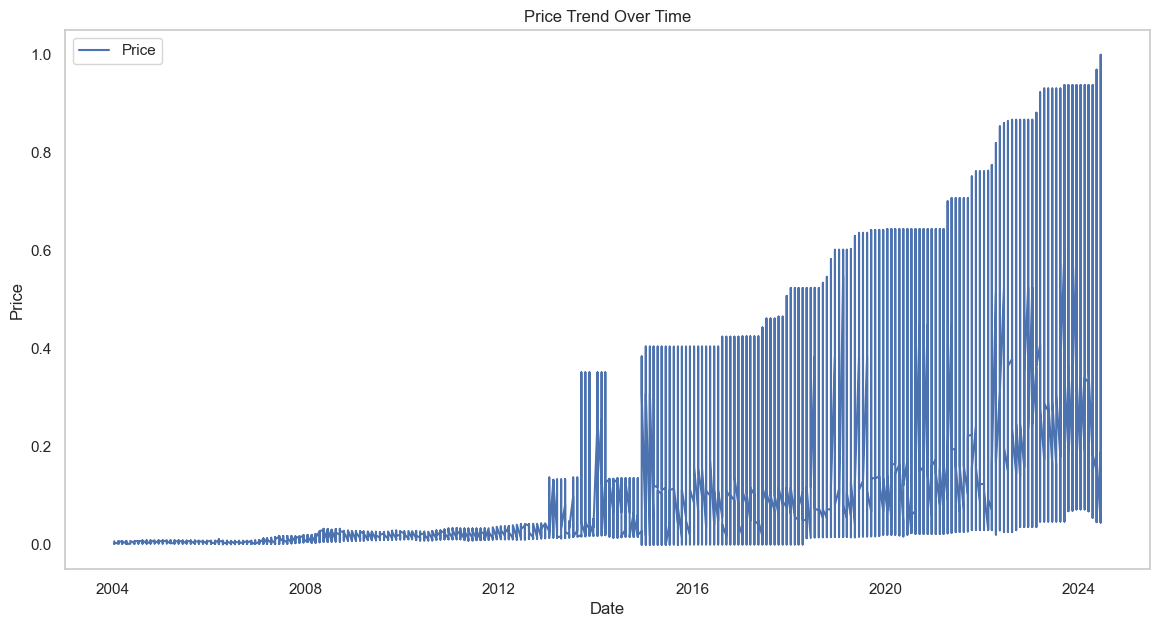

In [22]:
# Plot prices over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend Over Time')
plt.grid()
plt.legend()
plt.show()

# Trend Analysis

### Visualize Food Price Trends

To get an initial idea of how food prices have behaved over time, we can plot the prices

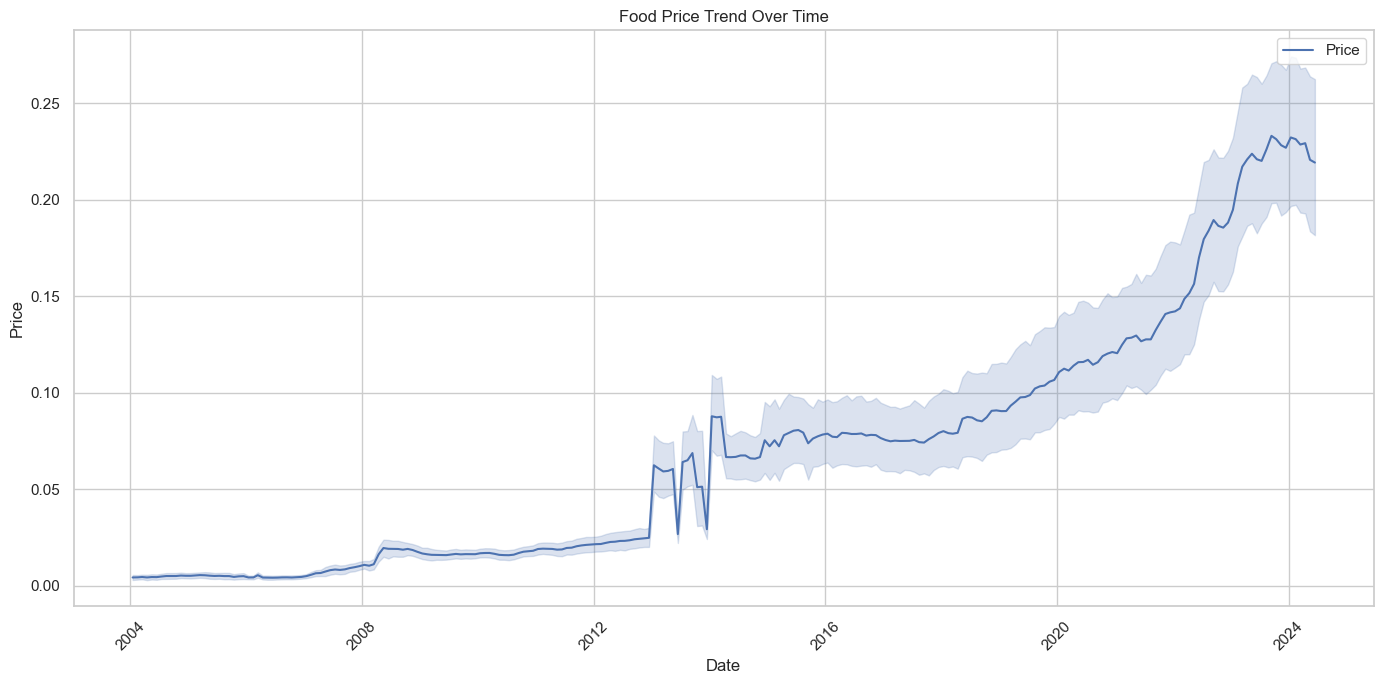

In [23]:
# Set the plot style for better aesthetics
sns.set(style="whitegrid")

# Plot the food prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='price', data=df, label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Food Price Trend Over Time')
plt.xticks(rotation=45)
plt.grid(visible=True)
plt.legend()
plt.tight_layout()
plt.show()

### Seasonal Analysis

To analyze seasonality and trends more formally, we can use time-series decomposition. This will allow us to break down the data into its trend, seasonality, and residual components

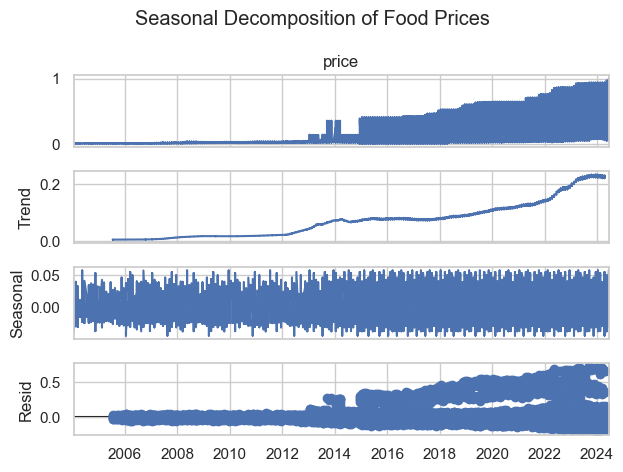

In [24]:
seasonal_df = df.set_index('date')

# Apply time-series decomposition (e.g., using 'price' as the target variable)
result = seasonal_decompose(seasonal_df['price'], model='additive', period=365)

# Plot the decomposition
result.plot()
plt.suptitle('Seasonal Decomposition of Food Prices')
plt.tight_layout()
plt.show()

Monthly Price Distribution

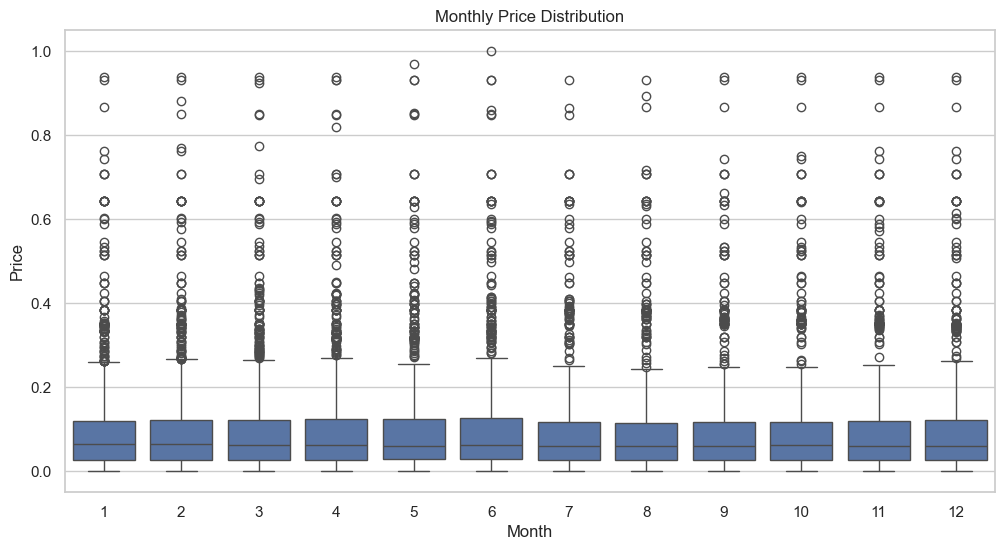

In [25]:
seasonal_df['month'] = seasonal_df.index.month

# Boxplot for monthly price trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='price', data=seasonal_df)
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Monthly Price Distribution')
plt.show()

# Relationship Analysis

### Correlation Matrix

Compute the correlation matrix of the numerical columns in the dataset. Since we're looking for relationships between food prices and other variables, we’ll focus on price-related columns like price, usdprice, and any other numerical columns that could be relevant.

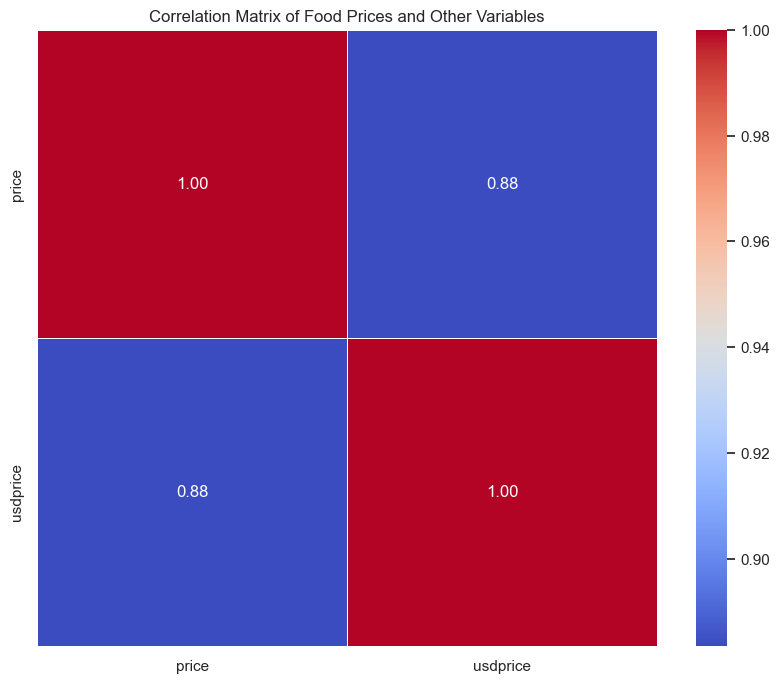

In [26]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Compute the correlation matrix for numeric columns
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Food Prices and Other Variables')
plt.show()

### Statistical Tests

To validate the relationships between different variables, we will apply statistical tests like Pearson or Spearman correlation coefficients. These tests assess the strength and direction of the relationship between two variables.

This will give you correlation values that range from -1 to 1, where:
- Pearson measures linear relationships.
- Spearman measures monotonic relationships, useful when data is not linearly related

In [27]:
# Pearson correlation test (for linear relationships)
pearson_corr, _ = pearsonr(df['price'], df['usdprice'])  # Example: price vs usdprice
print(f'Pearson Correlation between price and usdprice: {pearson_corr}')

# Spearman correlation test (for monotonic relationships)
spearman_corr, _ = spearmanr(df['price'], df['usdprice'])  # Example: price vs usdprice
print(f'Spearman Correlation between price and usdprice: {spearman_corr}')

Pearson Correlation between price and usdprice: 0.8835706281904097
Spearman Correlation between price and usdprice: 0.9148921590490333


# Impact of Oil Prices

### Multivariate Analysis

To analyze the correlation between oil prices and food items, we will use regression models to understand the relationship between oil prices and food prices. One of the common approaches is using linear regression or multiple linear regression if we want to include more factors (e.g., market, category) that may impact food prices.

Steps:
- Prepare the dataset by ensuring that oil prices are included as a feature.
- Use regression models like LinearRegression from sklearn to fit the data.
- Visualize the coefficients to understand the impact of oil prices on each commodity.

Coefficient for fuel price: [1.]
Intercept: 0.0


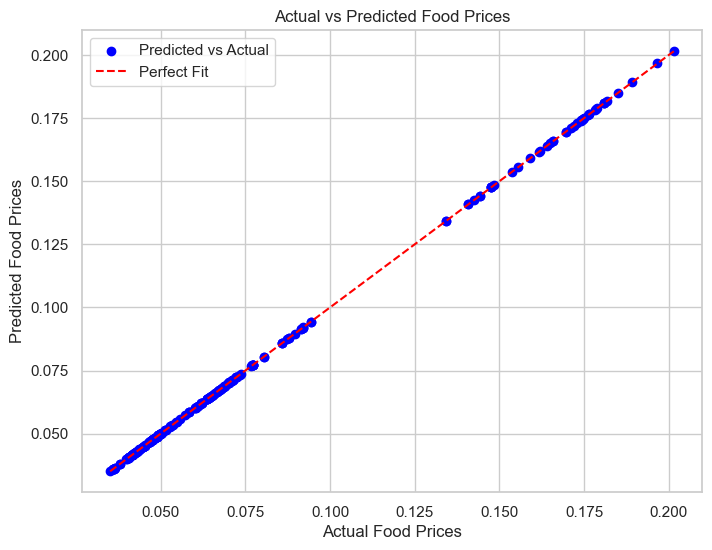

In [28]:
# Filter rows where 'commodity' is 'Fuel (diesel)' or 'Fuel (petrol-gasoline)'
oil_price_df = df[df['commodity'].isin(['Fuel (diesel)', 'Fuel (petrol-gasoline)'])]

# Check if the filtered dataset has data
if not oil_price_df.empty:
    # Select features and target variable
    X = oil_price_df[['price']]  # Independent variable: fuel price (as 'price' for these commodities)
    y = oil_price_df['price']    # Dependent variable: food price

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model
    model = LinearRegression()

    # Fit the model
    model.fit(X_train, y_train)

    # Print the regression coefficients
    print(f"Coefficient for fuel price: {model.coef_}")
    print(f"Intercept: {model.intercept_}")

    # Predict the food prices using the test set
    y_pred = model.predict(X_test)

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
    plt.title('Actual vs Predicted Food Prices')
    plt.xlabel('Actual Food Prices')
    plt.ylabel('Predicted Food Prices')
    plt.legend()
    plt.show()

else:
    print("No fuel price data available in the dataset")


# Economic Impact Estimation

### Regression Models (Linear Regression)

We will use Linear Regression to model the relationship between food prices and non-qualified labor wages (Wage (non-qualified labour, non-agricultural)) over time. Let's assume that food prices (price) are the independent variable and non-qualified labor wages are the dependent variable.

Coefficient for food price: [0.15112715]
Intercept: 0.6272230261246934


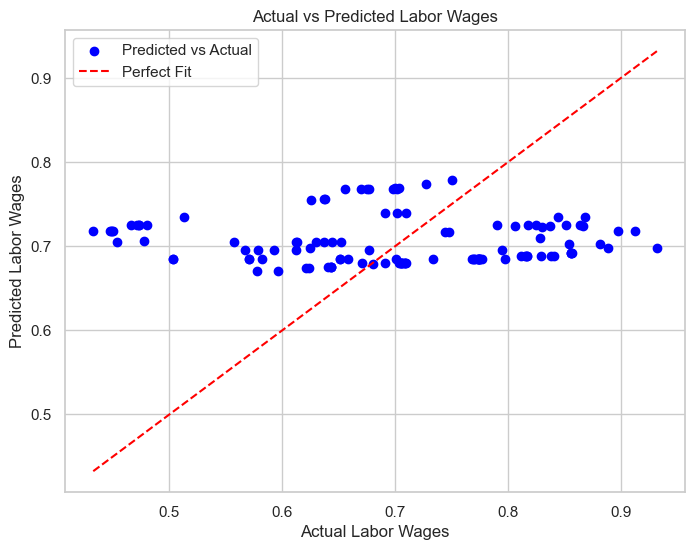

In [30]:
# Filter the dataset for the relevant commodity (Wage - non-qualified labour)
wage_data = df[df['commodity'] == 'Wage (non-qualified labour, non-agricultural)']

# Select features and target variable
X = wage_data[['price']]  # Independent variable: food prices
y = wage_data['usdprice']  # Dependent variable: non-qualified labor wages (or 'usdprice' as the wage proxy)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Print the regression coefficients
print(f"Coefficient for food price: {model.coef_}")
print(f"Intercept: {model.intercept_}")

# Predict the labor wages using the test set
y_pred = model.predict(X_test)

# Plot Actual vs Predicted wages
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.title('Actual vs Predicted Labor Wages')
plt.xlabel('Actual Labor Wages')
plt.ylabel('Predicted Labor Wages')
plt.legend()
plt.show()


### Model Evaluation

After fitting the model and making predictions, it's essential to evaluate the model performance beyond just plotting the predictions. Use evaluation metrics like Mean Squared Error (MSE) or R-squared (R²) to assess how well your model is performing.

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 0.0164
R-squared: -0.0822


# Comparative Analysis by Provinces

### Data Segmentation

We will first group the data by province (admin1) and commodity (commodity) and analyze how the price (price) of different commodities changes across provinces. We will calculate the average price for each commodity in each province over time.

In [32]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by 'admin1' (province), 'commodity', and 'date' and calculate the mean price
df_grouped = df.groupby(['admin1', 'commodity', 'date'])['price'].mean().reset_index()

print(df_grouped.head())

        admin1    commodity       date     price
0  BALOCHISTAN  Beans(mash) 2014-01-15  0.091678
1  BALOCHISTAN  Beans(mash) 2014-02-15  0.092490
2  BALOCHISTAN  Beans(mash) 2014-03-15  0.091678
3  BALOCHISTAN  Beans(mash) 2014-04-15  0.091678
4  BALOCHISTAN  Beans(mash) 2014-05-15  0.103869


### Visualization

To visualize the trends, we can use line plots or bar charts. We'll show the price trend for each commodity across different provinces using a line plot.

In [ ]:
# Filter data for the most recent date (or any specific date)
latest_data = df_grouped[df_grouped['date'] == df_grouped['date'].max()]

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot a bar chart for the average price by province for each commodity
sns.barplot(x='admin1', y='price', hue='commodity', data=latest_data)

# Set plot title and labels
plt.title('Average Price of Commodities by Province (Most Recent Date)')
plt.xlabel('Province')
plt.ylabel('Price (PKR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
